# ANALYSING CLIMBERS PEAK PERFORMANCE

## 06.04.2020

### Jaromir Panas

The goal of this project is to investigate, whether one can predict the best grade that a climber can do beased on: climb type, age, years of experience, date, height, weight, and sex. Some factors should have a clear impact on the top grade, like how many years of experience does a climber have. Relevance of other factors is less obvious, e.g., is it better to be higher to have a better reach, or rather smaller, to avoid cramped position on closely placed holds.

Firstly we investigate these questions by looking at the data: plotting their correlations and histograms. Next we try to build a Neural Network model that could predict the results.

The data was taken from https://www.kaggle.com/dcohen21/8anu-climbing-logbook/metadata. It was scraped by from the https://www.8a.nu/ rock climbing logbook on 13.09.2017 and is freely available. The database contains the following tables:

1) ascent -- list of ascents, with the following columns: id, user_id, grade_id, notes, raw_notes, method_id, climb_type, total_score, date, year, last_year, rec_date, project_ascent_date, name, crag_id, crag, sector_id, sector, country, comment, rating, description, yellow_id, climb_try, repeat, exclude_from_ranking, user_recommended, chipped

2) grade  -- list of climbing grades in different systems with the folloing columns: id, score, fra_routes, fra_routes_input, fra_routes_selector, fra_boulders, fra_boulders_input, fra_boulders_selector, usa_routes, usa_routes_input, usa_routes_selector, usa_boulders, usa_boulders_input, usa_boulders_selector

3) method -- list of methods of possible ways to do a route, with the following columns: id, score, shorthand, name

4) user   -- list of users and their perosnal information, with the following columns: id, first_name, last_name, city, country, sex, height, weight, started, competitions, occupation, sponsor1, sponsor2, sponsor3, best_area, worst_area, guide_area, interests, birth, presentation, deactivated, anonymous

Note: first and last names of the users are blank due to GDPR.

### STEP 1 -- Data extraction, cleaning, and preparation

Uploading, selecting the relevant records, cleaning the data.

In [1]:
# First we need to load appropriate modules.
import sqlite3                    # SQLITE3  -- Module needed to read and upload the data from the SQLITE database.
import pandas as pd               # PANDAS   -- We will store the data in a data frame.
import matplotlib.pyplot as plt   # MATPLOTLIB -- for plotting data
import numpy as np                # NUMPY -- for array/matrix manipulations
import tensorflow as tf           # TENSORFLOW -- for implementing models
import tensorflow.compat.v1 as tfv1           # TENSORFLOW -- for implementing models
tfv1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# Establish connection to the database.
conn = sqlite3.connect("E:\Python\Python35\LearnTensorflow\Climbing_logbook\database.sqlite")

Climbing grades: we store the climbing grade as an integer number. Towards the end we want to be able to translate it to a standard climbing grade scale. To this end we define a data frame df_grades. We will use French grading system. 

In [3]:
df_grades=pd.read_sql_query("select id, fra_routes, fra_boulders from grade;",conn)

In [4]:
df_grades.head()

,id,fra_routes,fra_boulders
0,1,-,-
1,2,1,1
2,3,1a,1A
3,4,1b,1B
4,5,1c,1C


#### DATA EXTRACTION

Now we select the relevant data from the database.<br>
From the ascent table we extract: user_id, year of ascent, highest grade achieved in this year and climbing type. We note that the notation of climb_type id the following: 0- rope climbing, 1- bouldering.<br>
From the user table we extract: id, sex (where 0- male, 1- female), height, weight, started (year in which the climber started), and birth (birth date).

In [5]:
df_data=pd.read_sql_query("""SELECT a.user_id, u.sex, u.height, u.weight, u.started, STRFTIME('%Y',u.birth) AS birth, a.date AS date, climb_type, a.max_grade as max_grade
FROM user u INNER JOIN (SELECT user_id, MAX(grade_id) AS max_grade, STRFTIME('%Y',DATETIME(date,'unixepoch')) AS date, climb_type
                        FROM ascent 
                        GROUP BY user_id, climb_type, STRFTIME('%Y',DATETIME(date,'unixepoch'))) AS a ON u.id=a.user_id
WHERE u.birth!='None'
""" ,conn)

In [6]:
print(df_data.shape)
print(df_data.dtypes)
df_data.head()

(137141, 9)
user_id        int64
sex            int64
height         int64
weight         int64
started        int64
birth         object
date          object
climb_type     int64
max_grade      int64
dtype: object


,user_id,sex,height,weight,started,birth,date,climb_type,max_grade
0,1,0,177,73,1996,1976,1998,0,49
1,1,0,177,73,1996,1976,1999,0,55
2,1,0,177,73,1996,1976,2000,0,57
3,1,0,177,73,1996,1976,2001,0,62
4,1,0,177,73,1996,1976,2002,0,53


#### DATA CLEANING

Next we need to clean the data. We have spotted the following issues with the records: format of columns _birth_ and _date_ (we want both to be integers), impossible/missing values of _birth_ date (e.g., 0), impossible/missing values of _started_ (e.g., 1901), impossible/missing values of _height_ (e.g., 0 or 260) and impossible/missing values of _weight_ (e.g., 0).

We adopt the following strategy to remove ill-defined values:<br>
1) _height_ and _weight_ -- we choose only values that are >0, we also check the body mass index (BMI) and restrict to the cases where 16<BMI<35. Values outside of this range correnspond to people that are extremely over-/undr-weight. Finally, we set _height_ < 210, as we are interested in climbers, not basketball players.<br>
2) _birth_ -- we choose only data with _birth_ satisfying 1950< _birth_ <2010. Upper boundary is set to 2010 as the data form database have been collected only up to 2017. We might lose some information about young climbers (born after 2010) but we rather aim at addressing adult climbers. Lower boundary removes unphysical values (such as 0, 1901, etc.),<br>
3) _started_ -- we choose only data where 1950< _started_ <=2017. We also impose condition _birth_ < _started_ <= _date_ as a natural limitation,<br>
4) _date_ -- we select only values with _date_ <=2017. Larger values of date are unphysical, as the data was collected in 2017.

We can also cast all the data into int format, as we don't have really large values.

In [7]:
# Casting to appropriate format
for col in df_data.columns:
    df_data[col] = df_data[col].astype(int)

In [8]:
# Removing bad records
# Select 0<height<210 and weight>0.
df_data_clean = df_data[(df_data['height']<210) & (df_data['height']>0) & (df_data['weight']>0)]
# Select 16 < BMI < 35 
df_data_clean = df_data_clean[(df_data_clean['weight']/(df_data_clean['height']/100)**2>16) & (df_data_clean['weight']/(df_data_clean['height']/100)**2<35)]
# Select 1950 < birth < 2010
df_data_clean = df_data_clean[(df_data_clean['birth']<2010) & (df_data_clean['birth']>1950)]
# Select started 1950 < started <= 2017
df_data_clean = df_data_clean[(df_data_clean['started']>1950) & (df_data_clean['started']<=2017)]
# Select date <= 2017
df_data_clean = df_data_clean[(df_data_clean['date']<= 2017)]
# Select birth < started <= date
df_data_clean = df_data_clean[(df_data_clean['birth']<df_data_clean['started']) & (df_data_clean['started']<df_data_clean['date'])]

print(df_data_clean.shape)
print(df_data_clean.dtypes)
df_data_clean.head()


(93163, 9)
user_id       int32
sex           int32
height        int32
weight        int32
started       int32
birth         int32
date          int32
climb_type    int32
max_grade     int32
dtype: object


,user_id,sex,height,weight,started,birth,date,climb_type,max_grade
0,1,0,177,73,1996,1976,1998,0,49
1,1,0,177,73,1996,1976,1999,0,55
2,1,0,177,73,1996,1976,2000,0,57
3,1,0,177,73,1996,1976,2001,0,62
4,1,0,177,73,1996,1976,2002,0,53


Finally we replace the birth and started columns with age ( _date-birth_ ) and experience ( _exp=date-started_ )

In [9]:
df_data_clean['birth']=df_data_clean['date']-df_data_clean['birth']
df_data_clean['started']=df_data_clean['date']-df_data_clean['started']
df_data_clean=df_data_clean.rename(columns={"birth": "age_done", "started": "exp"})
df_data_clean.head()

,user_id,sex,height,weight,exp,age_done,date,climb_type,max_grade
0,1,0,177,73,2,22,1998,0,49
1,1,0,177,73,3,23,1999,0,55
2,1,0,177,73,4,24,2000,0,57
3,1,0,177,73,5,25,2001,0,62
4,1,0,177,73,6,26,2002,0,53


### STEP 2 -- Examination of data

After preparation and cleaning we examine the data. We look at the averages, standard deviation, and relations between different values. In order to skip doing certain steps more than once we will first split the dataset into train and test sets and then examine the train set. We also split the columns into input data and labels/values.<br>
We treat the _max_grade_ as a label/value that we want later to predict.<br>
_User_id_ does not represent relevant data so we drop it.

In [10]:
# Shuffle and split into train and test
data_train = df_data_clean.sample(frac=0.9,random_state=0)
data_test = df_data_clean.drop(data_train.index)

In [11]:
# Drop _user_id_
data_train=data_train.drop(['user_id'],axis=1)
data_test =data_test.drop(['user_id'],axis=1)

In [12]:
# The basic information about the data
train_stats = data_train.describe().transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
sex,83847.0,0.092609,0.289886,0.0,0.0,0.0,0.0,1.0
height,83847.0,176.486839,8.339584,110.0,172.0,177.0,182.0,208.0
weight,83847.0,68.322850,9.434175,40.0,63.0,68.0,73.0,100.0
exp,83847.0,8.636648,6.622215,1.0,4.0,7.0,12.0,49.0
age_done,83847.0,28.105025,7.779539,4.0,23.0,27.0,33.0,66.0
date,83847.0,2009.964877,4.753512,1979.0,2007.0,2010.0,2014.0,2017.0
climb_type,83847.0,0.357651,0.479312,0.0,0.0,0.0,1.0,1.0
max_grade,83847.0,53.889346,8.640594,1.0,49.0,55.0,59.0,83.0


Basic statistcs of the data. We plot the histograms for each column.

Text(0.5, 1.0, 'max_grade')

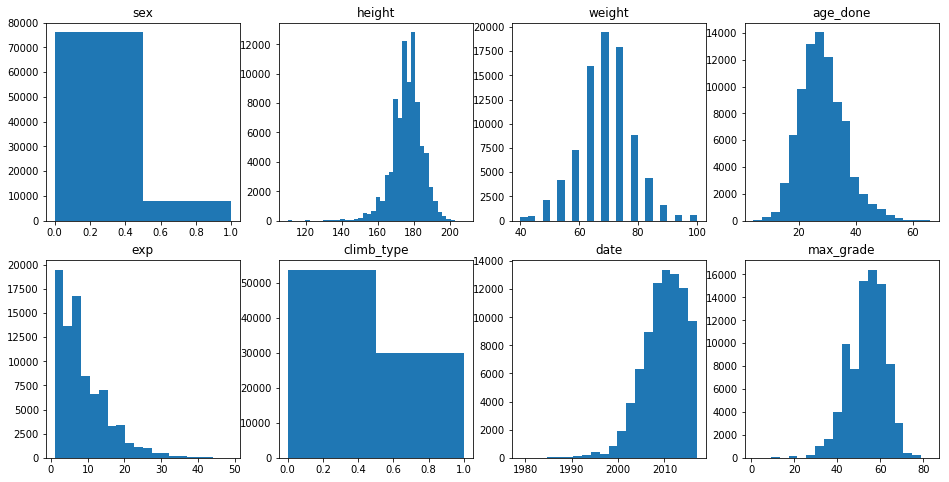

In [13]:
fig,ax = plt.subplots(2,4,figsize=(16.,8.))
ax[0][0].hist(data_train['sex'], bins=2)
ax[0][0].set_title('sex')
ax[0][1].hist(data_train['height'], bins=40)
ax[0][1].set_title('height')
ax[0][2].hist(data_train['weight'], bins=24)
ax[0][2].set_title('weight')
ax[0][3].hist(data_train['age_done'], bins=20)
ax[0][3].set_title('age_done')
ax[1][0].hist(data_train['exp'], bins=20)
ax[1][0].set_title('exp')
ax[1][1].hist(data_train['climb_type'], bins=2)
ax[1][1].set_title('climb_type')
ax[1][2].hist(data_train['date'], bins=20)
ax[1][2].set_title('date')
ax[1][3].hist(data_train['max_grade'], bins=20)
ax[1][3].set_title('max_grade')


We note the follwing observations:<br>
1) There are much more data about male-ascends. This might later translate to less accurate predicitons of a model that is trained on both categories. Splitting the data into two sets might be beneficial.<br>
2) Height and weight seem to have approximate Gaussian distribution. Lack of bimodality is due to much larger number of males than females in the sample.<br>
3) There seems to be about two times as much data for rope climbing (climbing type 0) than bouldering (climbing_type 1). Nevetheless this shouldn't affect much the performance of a model.<br>
4) _max_grade_ , _experience_ , _age_done_ and _date_ do not have Gaussian distribution.

We next look into relations between different quantities for each of the categorical variables separately ( _sex_ and _climb_type_ ).

In [14]:
data_train_s0_ct0=data_train[(data_train['sex']==0) & (data_train['climb_type']==0)]
data_train_s1_ct0=data_train[(data_train['sex']==1) & (data_train['climb_type']==0)]
data_train_s0_ct1=data_train[(data_train['sex']==0) & (data_train['climb_type']==1)]
data_train_s1_ct1=data_train[(data_train['sex']==1) & (data_train['climb_type']==1)]

##### Height vs weight

Before we examine the relation bewteen different parameters against the highest grade achieved (by given climber in given year) we take a short detour and look at the relation between height and weight. We will test a hypothesis, that since weight should be roughly proportional to a persons volume, it should be related to the third power of height.<br>
We will examine the data for men and women seperately as well as for rope climbers and boulderers.

Text(0.5, 1.0, 'Female Bouldering')

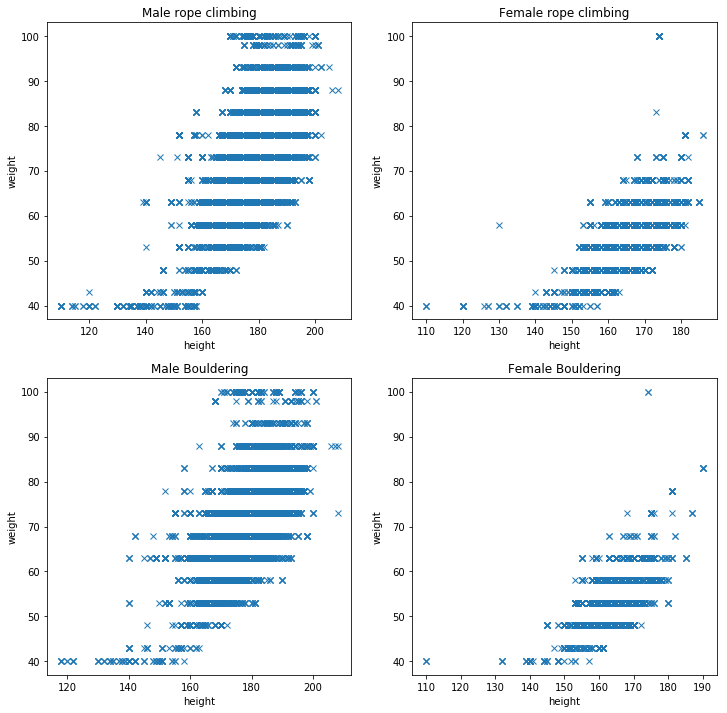

In [15]:
fig,ax = plt.subplots(2,2,figsize=(12.,12.))

ax[0][0].plot(data_train_s0_ct0['height'],data_train_s0_ct0['weight'],'x')
ax[0][0].set_xlabel('height')
ax[0][0].set_ylabel('weight')
ax[0][0].set_title('Male rope climbing')

ax[0][1].plot(data_train_s1_ct0['height'],data_train_s1_ct0['weight'],'x')
ax[0][1].set_xlabel('height')
ax[0][1].set_ylabel('weight')
ax[0][1].set_title('Female rope climbing')

ax[1][0].plot(data_train_s0_ct1['height'],data_train_s0_ct1['weight'],'x')
ax[1][0].set_xlabel('height')
ax[1][0].set_ylabel('weight')
ax[1][0].set_title('Male Bouldering')

ax[1][1].plot(data_train_s1_ct1['height'],data_train_s1_ct1['weight'],'x')
ax[1][1].set_xlabel('height')
ax[1][1].set_ylabel('weight')
ax[1][1].set_title('Female Bouldering')

At this point we want to build a small model to check, whether the relation between height and weight of a climber can be described with a third order polynomial function. We build one using tensorflow v1 to check this.

Polynomial after fit is: X**3 (-0.00304762) + X**2 (0.0082516) + X (0.681416) + (0.04975397)


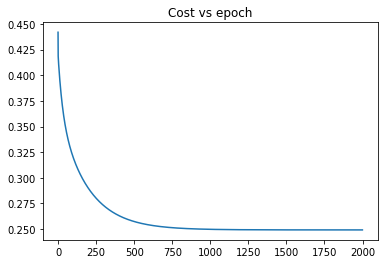

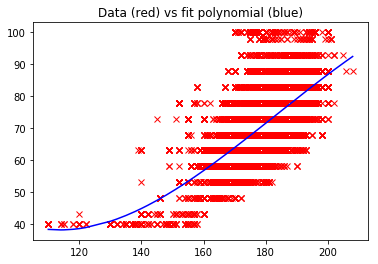

In [126]:
x=data_train_s0_ct0['height'].astype(float).values # data height on example of men rope climbing
y=data_train_s0_ct0['weight'].astype(float).values # data weight on example of men rope climbing
x=(x-176)/8 # normalize the data
y=(y-68)/9  # normalize the data
m=len(x)  # number of data points

x=x.reshape((len(x),1))
y=y.reshape((len(y),1))
alpha=0.005
epochs=2000
errors = []

X = tfv1.placeholder(tfv1.float32,shape=[None,1],name='x-input')
Y = tfv1.placeholder(tfv1.float32,shape=[None,1],name='y-input')
theta_1 = tfv1.Variable(tfv1.zeros([1,1]))
theta_2 = tfv1.Variable(tfv1.zeros([1,1]))
theta_3 = tfv1.Variable(tfv1.zeros([1,1]))
b       = tfv1.Variable(0.0)
assignop = theta_3.assign([[0.1]])

# Take cubic polynomial model
model = tfv1.matmul(tfv1.pow(X,3),theta_3) + tfv1.matmul(tfv1.pow(X,2),theta_2) + tfv1.matmul(X,theta_1) + b
cost  = tfv1.reduce_sum(tfv1.square(Y-model))/(2*m)

optimizer = tfv1.train.GradientDescentOptimizer(alpha).minimize(cost)
init = tfv1.global_variables_initializer()

with tfv1.Session() as sess:
    sess.run(init)
    sess.run(assignop)
    for i in range(epochs):
        sess.run(optimizer,feed_dict={X:x, Y:y})
        loss = sess.run(cost,feed_dict={X:x, Y:y})
        errors.append(loss)
    t0,t1,t2,t3=sess.run(b),sess.run(theta_1), sess.run(theta_2), sess.run(theta_3)

print("Polynomial after fit is: X**3 ("+str(t3[0][0])+") + X**2 ("+str(t2[0][0])+") + X ("+str(t1[0][0])+") + ("+str(t0)+")")

plt.plot(list(range(epochs)),errors)
plt.title("Cost vs epoch")
plt.show()

x0=x.copy()
x0=x0.reshape((x0.shape[0]))
x0.sort()

pred = t3[0][0]*x0*x0*x0+t2[0][0]*x0*x0+t1[0][0]*x0+t0
plt.plot((x*8+176),(y*9+68),'rx')
plt.plot((x0*8+176),(68+9*pred),'b-')
plt.title('Data (red) vs fit polynomial (blue)')
plt.show()

<br>
The fit does not seem be very accurate. The values of the fit are too large around _height_ ~= 120 and too small around _height_ ~= 200. This might be due to the sharp cuts of distribution of weight in our data. The weight never goes below 40kg and above 100kg even though that would seem intuitive for certain heights assuming gaussian distribution.

Another thing we might try is to fit a polynomial for a height as a function of weight: _height_ ( _weight_ ) (flip the axes).
We repeat the procedure below.
<br>

Polynomial after fit is: X**3 [[-0.00305029]]+ X**2[[-0.13663903]]+ X [[0.7092822]]+ 0.18873312


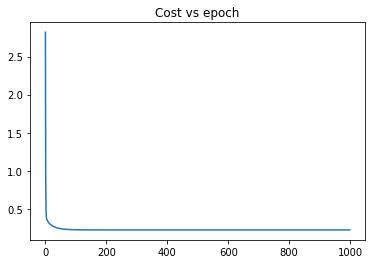

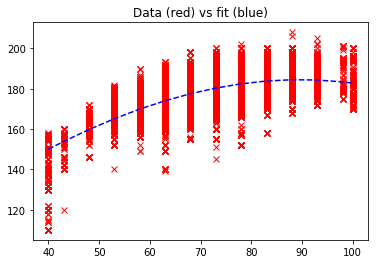

In [122]:
x=data_train_s0_ct0['weight'].astype(float).values # data height
y=data_train_s0_ct0['height'].astype(float).values # data weight
x=(x-68)/9
y=(y-176)/8
m=len(x)  # number of data points
x=x.reshape((len(x),1))
y=y.reshape((len(y),1))
alpha=0.05
epochs=1000
errors = []

X = tfv1.placeholder(tfv1.float32,shape=[None,1],name='x-input')
Y = tfv1.placeholder(tfv1.float32,shape=[None,1],name='y-input')
theta_1 = tfv1.Variable(tfv1.zeros([1,1]))
theta_2 = tfv1.Variable(tfv1.zeros([1,1]))
theta_3 = tfv1.Variable(tfv1.zeros([1,1]))
b       = tfv1.Variable(0.0)

model = tfv1.matmul(tfv1.pow(X,3),theta_3) + tfv1.matmul(tfv1.pow(X,2),theta_2) + tfv1.matmul(X,theta_1) + b
cost  = tfv1.reduce_sum(tfv1.square(Y-model))/(2*m)

optimizer = tfv1.train.GradientDescentOptimizer(alpha).minimize(cost)
init = tfv1.global_variables_initializer()

with tfv1.Session() as sess:
    sess.run(init)
    for i in range(epochs):
        sess.run(optimizer,feed_dict={X:x, Y:y})
        loss = sess.run(cost,feed_dict={X:x, Y:y})
        errors.append(loss)
    t0,t1,t2=sess.run(b),sess.run(theta_1), sess.run(theta_2)

print("Polynomial after fit is: X**3 "+str(t3)+"+ X**2"+str(t2)+"+ X "+str(t1)+"+ "+str(t0))

plt.plot(list(range(epochs)),errors)
plt.title("Cost vs epoch")
plt.show()

x0=x.copy()
x0=x0.reshape((x0.shape[0]))
x0.sort()

pred = t3[0][0]*x0*x0*x0+t2[0][0]*x0*x0+t1[0][0]*x0+t0
plt.plot(x*9+68,y*8+176,'rx')
plt.plot(x0*9+68,pred*8+176,'b--')
plt.title('Data (red) vs fit (blue)')
plt.show()

<br>
The fit seems to be better (lower value of cost) but less physical: the curve bends down fo large values of wieght. We also loose our explanaiton from original hypothesis that the third power comes from volume to length ratio.

The last approach we try is to simplify the fitting function. It might be that the unphysical behaviour comes form the overfitting. We threfore try to fit with a single parameter a function of the following form:<br>
_weight_ = ( _height_ )^3 * t1.<br>
We now try to fit the parameter t1.


Polynomial after fit is: X**3 (0.12317073) + X**2 (0.0) + X (0.0) + (0.0)


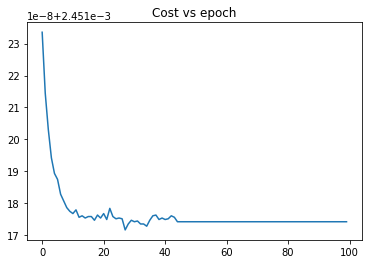

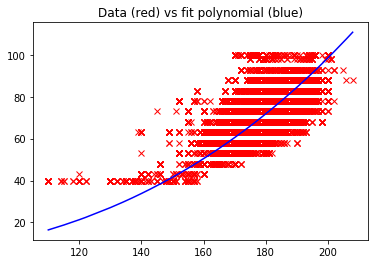

In [139]:
x=data_train_s0_ct0['height'].astype(float).values # data height on example of men rope climbing
y=data_train_s0_ct0['weight'].astype(float).values # data weight on example of men rope climbing
x=x/100 # "normalize" the data
y=y/100  # "normalize" the data
m=len(x)  # number of data points

x=x.reshape((len(x),1))
y=y.reshape((len(y),1))
alpha=0.005
epochs=100
errors = []

X = tfv1.placeholder(tfv1.float32,shape=[None,1],name='x-input')
Y = tfv1.placeholder(tfv1.float32,shape=[None,1],name='y-input')
theta_1 = tfv1.Variable(tfv1.zeros([1,1]))
theta_2 = tfv1.Variable(tfv1.zeros([1,1]))
theta_3 = tfv1.Variable(tfv1.zeros([1,1]))
b       = tfv1.Variable(0.0)
assignop = theta_3.assign([[0.1231]])

# Take cubic polynomial model
model = tfv1.matmul(tfv1.pow(X,3),theta_3)# + tfv1.matmul(tfv1.pow(X,2),theta_2) + tfv1.matmul(X,theta_1) + b
cost  = tfv1.reduce_sum(tfv1.square(Y-model))/(2*m)

optimizer = tfv1.train.GradientDescentOptimizer(alpha).minimize(cost)
init = tfv1.global_variables_initializer()

with tfv1.Session() as sess:
    sess.run(init)
    sess.run(assignop)
    for i in range(epochs):
        sess.run(optimizer,feed_dict={X:x, Y:y})
        loss = sess.run(cost,feed_dict={X:x, Y:y})
        errors.append(loss)
    t0,t1,t2,t3=sess.run(b),sess.run(theta_1), sess.run(theta_2), sess.run(theta_3)

print("Polynomial after fit is: X**3 ("+str(t3[0][0])+") + X**2 ("+str(t2[0][0])+") + X ("+str(t1[0][0])+") + ("+str(t0)+")")

plt.plot(list(range(epochs)),errors)
plt.title("Cost vs epoch")
plt.show()

x0=x.copy()
x0=x0.reshape((x0.shape[0]))
x0.sort()

pred = t3[0][0]*x0*x0*x0#+t2[0][0]*x0*x0+t1[0][0]*x0+t0
plt.plot((x*100),(y*100),'rx')
plt.plot((x0*100),(100*pred),'b-')
plt.title('Data (red) vs fit polynomial (blue)')
plt.show()

Even though the function is much simpler, the fit seems to better captrue the overall behavior of the data. We conclude that the assumption that the weight is related to height via<br>
_weight_ = ( _height_ )^3 * t1.<br>
is reasonable.

Next we continue examining the relation between the input parameters (height, weight, age, experience, and date) against output labels (highest grade achieved).

##### Height vs max_grade

In the plots below we show how the highest grade changes with height of the climber. The distribution seems to show very weak if any correlations.<br>
In order to make our observations more quantitative we also perform calculate the Pearson's correlation coefficient. The values confirm (absolute value always <0.1) that the correlations are weak. However, in all cases the values are negative. So the height seems to be very weakly disadvantagable.

In [145]:
rPearson_s0_ct0=data_train_s0_ct0.corr(method='pearson')
rPearson_s1_ct0=data_train_s1_ct0.corr(method='pearson')
rPearson_s0_ct1=data_train_s0_ct1.corr(method='pearson')
rPearson_s1_ct1=data_train_s1_ct1.corr(method='pearson')

Text(0.5, 1.0, 'Female Bouldering; rPearson coeff.: -0.098')

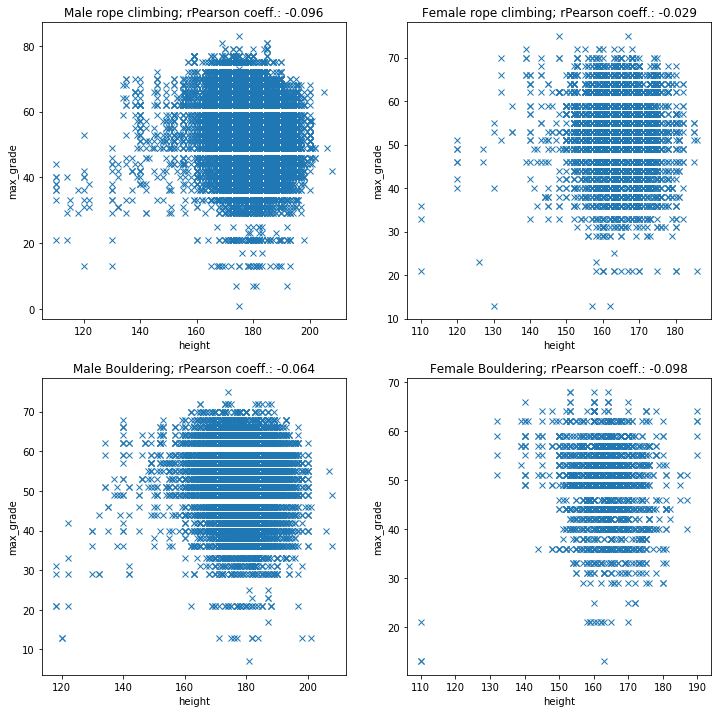

In [149]:
fig,ax = plt.subplots(2,2,figsize=(12.,12.))

ax[0][0].plot(data_train_s0_ct0['height'],data_train_s0_ct0['max_grade'],'x')
ax[0][0].set_xlabel('height')
ax[0][0].set_ylabel('max_grade')
ax[0][0].set_title('Male rope climbing; rPearson coeff.: {:.3f}'.format(rPearson_s0_ct0['height']['max_grade']))

ax[0][1].plot(data_train_s1_ct0['height'],data_train_s1_ct0['max_grade'],'x')
ax[0][1].set_xlabel('height')
ax[0][1].set_ylabel('max_grade')
ax[0][1].set_title('Female rope climbing; rPearson coeff.: {:.3f}'.format(rPearson_s1_ct0['height']['max_grade']))

ax[1][0].plot(data_train_s0_ct1['height'],data_train_s0_ct1['max_grade'],'x')
ax[1][0].set_xlabel('height')
ax[1][0].set_ylabel('max_grade')
ax[1][0].set_title('Male Bouldering; rPearson coeff.: {:.3f}'.format(rPearson_s0_ct1['height']['max_grade']))

ax[1][1].plot(data_train_s1_ct1['height'],data_train_s1_ct1['max_grade'],'x')
ax[1][1].set_xlabel('height')
ax[1][1].set_ylabel('max_grade')
ax[1][1].set_title('Female Bouldering; rPearson coeff.: {:.3f}'.format(rPearson_s1_ct1['height']['max_grade']))

##### Weight vs max_grade

In the plots below we show the relation between weight and climbers performance. Intuitively we would expect the larger weight to be disadvantagable for a climber. Indeed, there seems to be weak, but not negligible, correlation between the two values. The correlation is negative, which confirms our guess.

Text(0.5, 1.0, 'Female Bouldering; rPearson coeff.: -0.193')

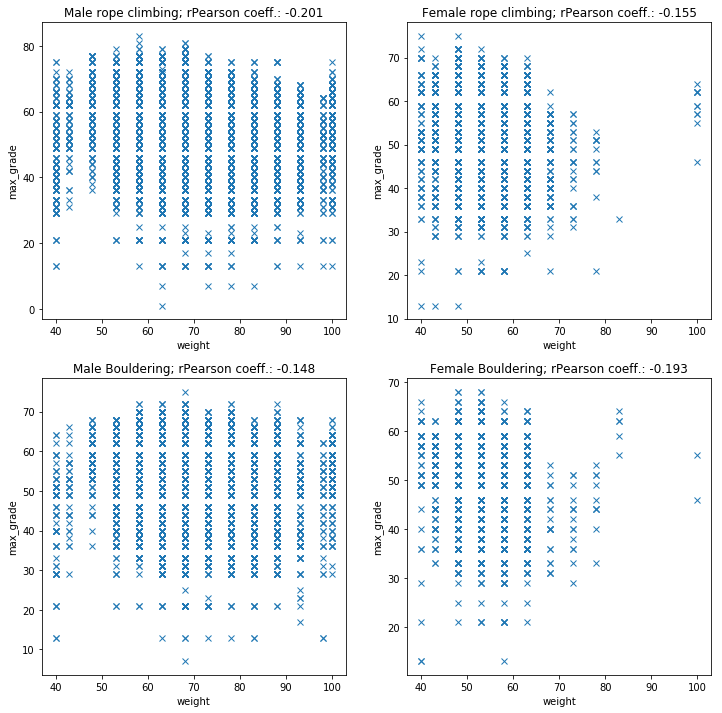

In [150]:
fig,ax = plt.subplots(2,2,figsize=(12.,12.))

ax[0][0].plot(data_train_s0_ct0['weight'],data_train_s0_ct0['max_grade'],'x')
ax[0][0].set_xlabel('weight')
ax[0][0].set_ylabel('max_grade')
ax[0][0].set_title('Male rope climbing; rPearson coeff.: {:.3f}'.format(rPearson_s0_ct0['weight']['max_grade']))

ax[0][1].plot(data_train_s1_ct0['weight'],data_train_s1_ct0['max_grade'],'x')
ax[0][1].set_xlabel('weight')
ax[0][1].set_ylabel('max_grade')
ax[0][1].set_title('Female rope climbing; rPearson coeff.: {:.3f}'.format(rPearson_s1_ct0['weight']['max_grade']))

ax[1][0].plot(data_train_s0_ct1['weight'],data_train_s0_ct1['max_grade'],'x')
ax[1][0].set_xlabel('weight')
ax[1][0].set_ylabel('max_grade')
ax[1][0].set_title('Male Bouldering; rPearson coeff.: {:.3f}'.format(rPearson_s0_ct1['weight']['max_grade']))

ax[1][1].plot(data_train_s1_ct1['weight'],data_train_s1_ct1['max_grade'],'x')
ax[1][1].set_xlabel('weight')
ax[1][1].set_ylabel('max_grade')
ax[1][1].set_title('Female Bouldering; rPearson coeff.: {:.3f}'.format(rPearson_s1_ct1['weight']['max_grade']))

##### Age vs max_grade

In the plots below we show the relation between the age and performance of a climber. Intuitively we would expect peak performance for age between 15 and 30 years. Indeed, there seems to be slightly visible sweet spot in the data seen of figures. Because this relation is not linear, we do not expect Pearson coefficient to show strong correlations. Indeed, values are small and even not consistent in sign.

Text(0.5, 1.0, 'Female Bouldering; rPearson coeff.: -0.053')

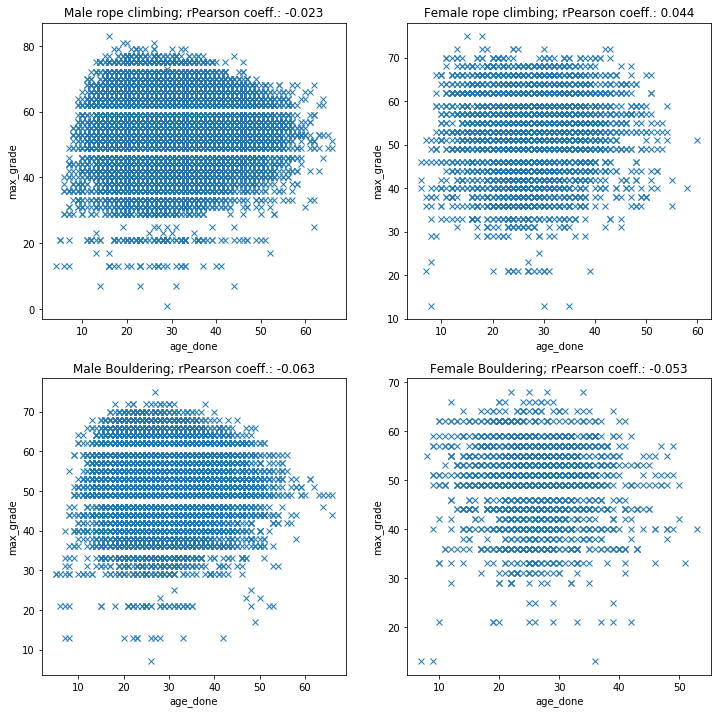

In [151]:
fig,ax = plt.subplots(2,2,figsize=(12.,12.))

ax[0][0].plot(data_train_s0_ct0['age_done'],data_train_s0_ct0['max_grade'],'x')
ax[0][0].set_xlabel('age_done')
ax[0][0].set_ylabel('max_grade')
ax[0][0].set_title('Male rope climbing; rPearson coeff.: {:.3f}'.format(rPearson_s0_ct0['age_done']['max_grade']))

ax[0][1].plot(data_train_s1_ct0['age_done'],data_train_s1_ct0['max_grade'],'x')
ax[0][1].set_xlabel('age_done')
ax[0][1].set_ylabel('max_grade')
ax[0][1].set_title('Female rope climbing; rPearson coeff.: {:.3f}'.format(rPearson_s1_ct0['age_done']['max_grade']))

ax[1][0].plot(data_train_s0_ct1['age_done'],data_train_s0_ct1['max_grade'],'x')
ax[1][0].set_xlabel('age_done')
ax[1][0].set_ylabel('max_grade')
ax[1][0].set_title('Male Bouldering; rPearson coeff.: {:.3f}'.format(rPearson_s0_ct1['age_done']['max_grade']))

ax[1][1].plot(data_train_s1_ct1['age_done'],data_train_s1_ct1['max_grade'],'x')
ax[1][1].set_xlabel('age_done')
ax[1][1].set_ylabel('max_grade')
ax[1][1].set_title('Female Bouldering; rPearson coeff.: {:.3f}'.format(rPearson_s1_ct1['age_done']['max_grade']))

##### Experience vs max_grade

In the plots below we show the relation between the experience and performance of a climber. Intuitively we would expect the performance to increase with years of experience. However, this cannot continue indefinitely, as at some point the reduction of physical capabilities due to age should again reduce the performance. In the figures we see an increasing trend for the first years of gaining experience. Then the increase slows down (less examples of very high performance, but also less examples of very low performance).<br>
Pearson's coefficients confirm quite significant positive correlation between experience and performance. It also seems that women tend to improve more consistently than men.

Text(0.5, 1.0, 'Female Bouldering; rPearson coeff.: 0.377')

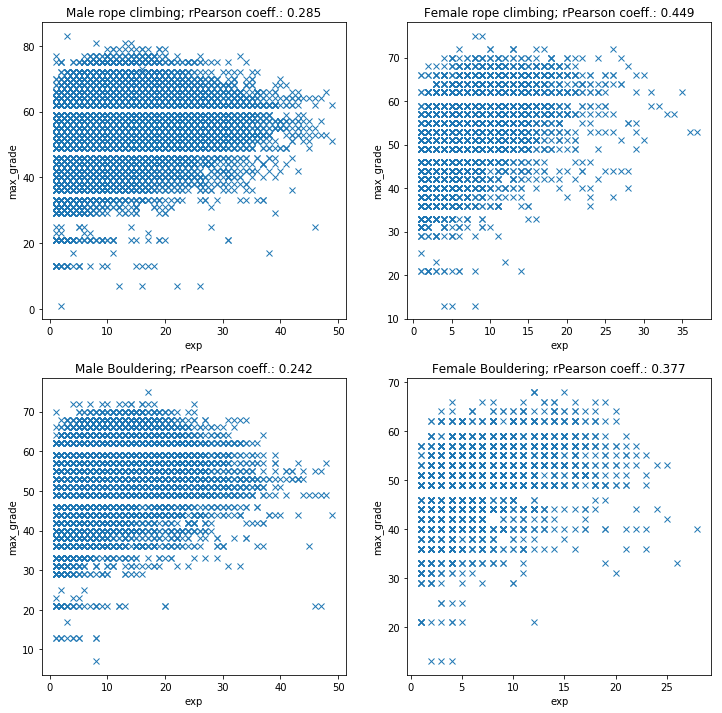

In [152]:
fig,ax = plt.subplots(2,2,figsize=(12.,12.))

ax[0][0].plot(data_train_s0_ct0['exp'],data_train_s0_ct0['max_grade'],'x')
ax[0][0].set_xlabel('exp')
ax[0][0].set_ylabel('max_grade')
ax[0][0].set_title('Male rope climbing; rPearson coeff.: {:.3f}'.format(rPearson_s0_ct0['exp']['max_grade']))

ax[0][1].plot(data_train_s1_ct0['exp'],data_train_s1_ct0['max_grade'],'x')
ax[0][1].set_xlabel('exp')
ax[0][1].set_ylabel('max_grade')
ax[0][1].set_title('Female rope climbing; rPearson coeff.: {:.3f}'.format(rPearson_s1_ct0['exp']['max_grade']))

ax[1][0].plot(data_train_s0_ct1['exp'],data_train_s0_ct1['max_grade'],'x')
ax[1][0].set_xlabel('exp')
ax[1][0].set_ylabel('max_grade')
ax[1][0].set_title('Male Bouldering; rPearson coeff.: {:.3f}'.format(rPearson_s0_ct1['exp']['max_grade']))

ax[1][1].plot(data_train_s1_ct1['exp'],data_train_s1_ct1['max_grade'],'x')
ax[1][1].set_xlabel('exp')
ax[1][1].set_ylabel('max_grade')
ax[1][1].set_title('Female Bouldering; rPearson coeff.: {:.3f}'.format(rPearson_s1_ct1['exp']['max_grade']))

##### Date vs max_grade

In the plots below we show the relation between the date (year) when a climb was achieved and performance of a climber. Intuitively we would expect the performance to increase with time, as the climbing community grows, there is more infrastructure for the climbers to train and improve. The increasing trend can be clearly seen in the performance of top athletes (not included in here). However, ther increasing infrastructure and cummunity might also lead to increasing number of casual climbers, not interested in doing very difficult climbs. Also, if there is indeed increasing trend, such a process should be quite slow and our data cover only last 20 to 40 years.<br>
In conclusion the Pearson coefficients show a sligh positive correlation but it is hard to determine unambiguously a clear trend.

Text(0.5, 1.0, 'Female Bouldering; rPearson coeff.: 0.178')

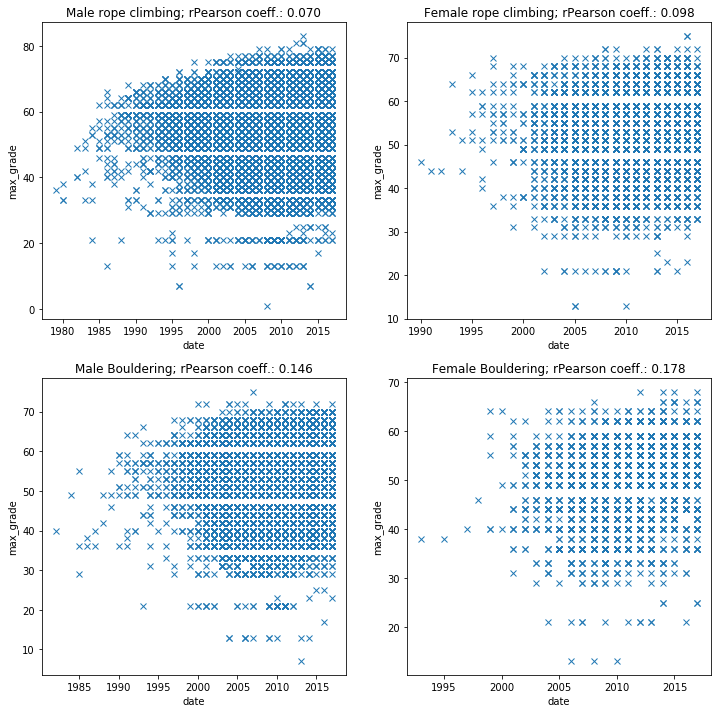

In [153]:
fig,ax = plt.subplots(2,2,figsize=(12.,12.))

ax[0][0].plot(data_train_s0_ct0['date'],data_train_s0_ct0['max_grade'],'x')
ax[0][0].set_xlabel('date')
ax[0][0].set_ylabel('max_grade')
ax[0][0].set_title('Male rope climbing; rPearson coeff.: {:.3f}'.format(rPearson_s0_ct0['date']['max_grade']))

ax[0][1].plot(data_train_s1_ct0['date'],data_train_s1_ct0['max_grade'],'x')
ax[0][1].set_xlabel('date')
ax[0][1].set_ylabel('max_grade')
ax[0][1].set_title('Female rope climbing; rPearson coeff.: {:.3f}'.format(rPearson_s1_ct0['date']['max_grade']))

ax[1][0].plot(data_train_s0_ct1['date'],data_train_s0_ct1['max_grade'],'x')
ax[1][0].set_xlabel('date')
ax[1][0].set_ylabel('max_grade')
ax[1][0].set_title('Male Bouldering; rPearson coeff.: {:.3f}'.format(rPearson_s0_ct1['date']['max_grade']))

ax[1][1].plot(data_train_s1_ct1['date'],data_train_s1_ct1['max_grade'],'x')
ax[1][1].set_xlabel('date')
ax[1][1].set_ylabel('max_grade')
ax[1][1].set_title('Female Bouldering; rPearson coeff.: {:.3f}'.format(rPearson_s1_ct1['date']['max_grade']))

### STEP 3 -- Building predictive model

We now turn to building a predictive model. We want to guess the performance of a climber based on his height, weight, sex, prefered climbing style, age, and experience.<br>
Because the amount of data for men and women are significantly different, we will separate these two categories and build separate models for each.
We use tensorflow to build and train a small neural network model.

In [155]:
# Separate data for men and women in both train and test sets
data_train_s0 = data_train[(data_train['sex']==0)]
data_train_s1 = data_train[(data_train['sex']==1)]
data_test_s0  = data_test[(data_test['sex']==0)]
data_test_s1  = data_test[(data_test['sex']==1)]

# Drop dummy variables
data_train_s0=data_train_s0.drop(['sex'],axis=1)
data_train_s1=data_train_s1.drop(['sex'],axis=1)
data_test_s0=data_test_s0.drop(['sex'],axis=1)
data_test_s1=data_test_s1.drop(['sex'],axis=1)

# Separate input from labels
labels_train_s0 = data_train_s0.pop('max_grade')
labels_train_s1 = data_train_s1.pop('max_grade')
labels_test_s0 = data_test_s0.pop('max_grade')
labels_test_s1 = data_test_s1.pop('max_grade')

# Gather new statistics
train_stats_s0 = data_train_s0.describe().transpose()
print(train_stats_s0)
train_stats_s1 = data_train_s1.describe().transpose()
print(train_stats_s1)

              count         mean       std     min     25%     50%     75%  \
height      76082.0   177.753779  7.307859   110.0   173.0   178.0   182.0   
weight      76082.0    69.818945  8.351081    40.0    63.0    68.0    73.0   
exp         76082.0     8.798375  6.740064     1.0     4.0     7.0    12.0   
age_done    76082.0    28.192792  7.800642     4.0    23.0    27.0    33.0   
date        76082.0  2009.906206  4.801646  1979.0  2007.0  2010.0  2014.0   
climb_type  76082.0     0.362293  0.480666     0.0     0.0     0.0     1.0   

               max  
height       208.0  
weight       100.0  
exp           49.0  
age_done      66.0  
date        2017.0  
climb_type     1.0  
             count         mean       std     min     25%     50%     75%  \
height      7765.0   164.073278  7.609795   110.0   160.0   164.0   169.0   
weight      7765.0    53.664005  6.398037    40.0    48.0    53.0    58.0   
exp         7765.0     7.052028  5.065630     1.0     3.0     6.0    10.0  

Next we normalize the data

In [161]:
def norm(x,y):
    if(y=='0'):
        return (x-train_stats_s0['mean'])/train_stats_s0['std']
    else:
        return (x-train_stats_s1['mean'])/train_stats_s1['std']
norm_data_train_s0 = norm(data_train_s0,'0')
norm_data_test_s0 = norm(data_test_s0,'0')
norm_data_train_s1 = norm(data_train_s1,'1')
norm_data_test_s1 = norm(data_test_s1,'1')

In [162]:
norm_data_train_s0.head()

,height,weight,exp,age_done,date,climb_type
121753,-0.376824,-0.217810,-1.008651,-1.050271,0.644319,-0.753732
91175,0.581049,1.578365,0.475014,1.641815,0.852581,-0.753732
52142,1.675761,0.380915,-0.266819,-0.024715,0.644319,1.326714
19263,1.675761,0.979640,3.887444,2.410982,1.060843,1.326714
63045,-1.061019,-0.816534,0.178281,-0.281104,1.477367,1.326714


Now we create a NN model to analyze the data and make predictions on max_grade stored in 

In [168]:
in_shape=len(norm_data_train_s0.keys())

In [231]:
def build_model():
    model=tf.keras.Sequential([
        tf.keras.layers.Dense(4,activation=tf.nn.relu,input_shape=[in_shape]),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01),loss='mse',metrics=['mse','mae'])
    
    return model

model_s0=build_model()

In [232]:
model_s0.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 4)                 28        
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 5         
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


In [233]:
Nepochs=100
history= model_s0.fit(
    norm_data_train_s0,
    labels_train_s0,
    epochs=Nepochs,
    verbose=2,
    validation_split=0.1
)

Train on 68473 samples, validate on 7609 samples
Epoch 1/100
68473/68473 - 3s - loss: 267.1979 - mean_squared_error: 267.1980 - mean_absolute_error: 10.3552 - val_loss: 61.7473 - val_mean_squared_error: 61.7473 - val_mean_absolute_error: 6.2535
Epoch 2/100
68473/68473 - 2s - loss: 60.4108 - mean_squared_error: 60.4108 - mean_absolute_error: 6.0945 - val_loss: 60.9042 - val_mean_squared_error: 60.9042 - val_mean_absolute_error: 6.1645
Epoch 3/100
68473/68473 - 2s - loss: 60.3400 - mean_squared_error: 60.3400 - mean_absolute_error: 6.0961 - val_loss: 60.1749 - val_mean_squared_error: 60.1749 - val_mean_absolute_error: 6.0787
Epoch 4/100
68473/68473 - 2s - loss: 60.4259 - mean_squared_error: 60.4260 - mean_absolute_error: 6.0950 - val_loss: 60.2053 - val_mean_squared_error: 60.2053 - val_mean_absolute_error: 6.0699
Epoch 5/100
68473/68473 - 2s - loss: 60.4056 - mean_squared_error: 60.4057 - mean_absolute_error: 6.0960 - val_loss: 60.2938 - val_mean_squared_error: 60.2938 - val_mean_absolu

68473/68473 - 2s - loss: 54.5919 - mean_squared_error: 54.5919 - mean_absolute_error: 5.7654 - val_loss: 54.8335 - val_mean_squared_error: 54.8335 - val_mean_absolute_error: 5.7775
Epoch 44/100
68473/68473 - 2s - loss: 54.6217 - mean_squared_error: 54.6217 - mean_absolute_error: 5.7657 - val_loss: 54.2925 - val_mean_squared_error: 54.2925 - val_mean_absolute_error: 5.7705
Epoch 45/100
68473/68473 - 2s - loss: 54.6339 - mean_squared_error: 54.6339 - mean_absolute_error: 5.7705 - val_loss: 54.4214 - val_mean_squared_error: 54.4214 - val_mean_absolute_error: 5.7903
Epoch 46/100
68473/68473 - 2s - loss: 54.5817 - mean_squared_error: 54.5816 - mean_absolute_error: 5.7688 - val_loss: 57.8159 - val_mean_squared_error: 57.8159 - val_mean_absolute_error: 6.0571
Epoch 47/100
68473/68473 - 2s - loss: 54.6581 - mean_squared_error: 54.6582 - mean_absolute_error: 5.7697 - val_loss: 55.7623 - val_mean_squared_error: 55.7623 - val_mean_absolute_error: 5.9120
Epoch 48/100
68473/68473 - 2s - loss: 54.57

Epoch 86/100
68473/68473 - 2s - loss: 54.5820 - mean_squared_error: 54.5820 - mean_absolute_error: 5.7689 - val_loss: 54.4291 - val_mean_squared_error: 54.4291 - val_mean_absolute_error: 5.7459
Epoch 87/100
68473/68473 - 2s - loss: 54.5367 - mean_squared_error: 54.5367 - mean_absolute_error: 5.7617 - val_loss: 55.3881 - val_mean_squared_error: 55.3881 - val_mean_absolute_error: 5.8698
Epoch 88/100
68473/68473 - 2s - loss: 54.5540 - mean_squared_error: 54.5539 - mean_absolute_error: 5.7621 - val_loss: 55.0076 - val_mean_squared_error: 55.0076 - val_mean_absolute_error: 5.8473
Epoch 89/100
68473/68473 - 2s - loss: 54.5531 - mean_squared_error: 54.5532 - mean_absolute_error: 5.7667 - val_loss: 54.9099 - val_mean_squared_error: 54.9099 - val_mean_absolute_error: 5.8340
Epoch 90/100
68473/68473 - 2s - loss: 54.5244 - mean_squared_error: 54.5244 - mean_absolute_error: 5.7654 - val_loss: 55.3319 - val_mean_squared_error: 55.3319 - val_mean_absolute_error: 5.8515
Epoch 91/100
68473/68473 - 2s 

In [234]:
hist=pd.DataFrame(history.history)
hist['epoch']=history.epoch
hist.head()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
0,267.197940,10.355177,267.198029,61.747285,6.253497,61.747295,0
1,60.410801,6.094491,60.410801,60.904192,6.164523,60.904209,1
2,60.339998,6.096121,60.339970,60.174851,6.078672,60.174850,2
3,60.425949,6.094990,60.426006,60.205276,6.069854,60.205273,3
4,60.405645,6.096012,60.405704,60.293769,6.078322,60.293762,4


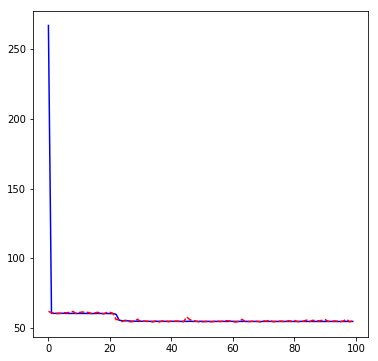

In [235]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
#ax.set_yscale('log')
#ax.set_ylim((40,100))
ax=plt.plot(hist['epoch'],hist['mean_squared_error'],'b-')
ax=plt.plot(hist['epoch'],hist['val_mean_squared_error'],'r--')

In [236]:
model_s0.evaluate(norm_data_test_s0,labels_test_s0,verbose=2)

8472/8472 - 0s - loss: 56.3541 - mean_squared_error: 56.3541 - mean_absolute_error: 5.7601


[56.35409244036652, 56.354073, 5.760107]

Text(0.5, 1.0, 'Prediction vs train')

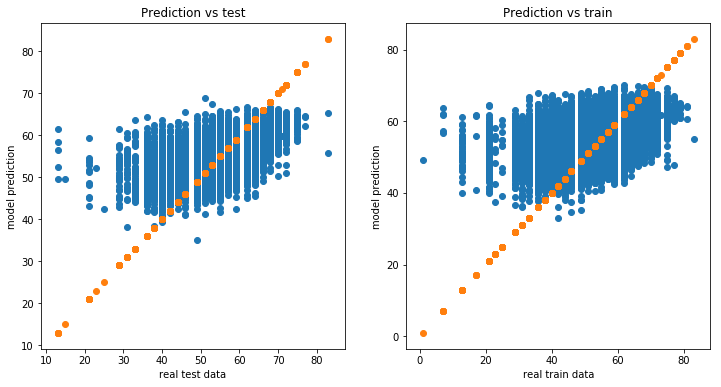

In [237]:
test_predictions = model_s0.predict(norm_data_test_s0).flatten()
train_predictions = model_s0.predict(norm_data_train_s0).flatten()

fig,ax = plt.subplots(1,2,figsize=(12,6))

ax[0].scatter(labels_test_s0,test_predictions)
ax[0].scatter(labels_test_s0,labels_test_s0)

ax[1].scatter(labels_train_s0,train_predictions)
ax[1].scatter(labels_train_s0,labels_train_s0)

ax[0].set_xlabel('real test data')
ax[0].set_ylabel('model prediction')
ax[0].set_title('Prediction vs test')

ax[1].set_xlabel('real train data')
ax[1].set_ylabel('model prediction')
ax[1].set_title('Prediction vs train')

In [238]:
model_s1=build_model()
model_s1.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 4)                 28        
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 5         
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


In [239]:
Nepochs=100
history_s1= model_s1.fit(
    norm_data_train_s1,
    labels_train_s1,
    epochs=Nepochs,
    verbose=2,
    validation_split=0.1
)

Train on 6988 samples, validate on 777 samples
Epoch 1/100
6988/6988 - 1s - loss: 1367.9972 - mean_squared_error: 1367.9969 - mean_absolute_error: 33.9133 - val_loss: 332.8344 - val_mean_squared_error: 332.8344 - val_mean_absolute_error: 15.2003
Epoch 2/100
6988/6988 - 0s - loss: 129.7837 - mean_squared_error: 129.7838 - mean_absolute_error: 8.8250 - val_loss: 73.2360 - val_mean_squared_error: 73.2360 - val_mean_absolute_error: 6.6983
Epoch 3/100
6988/6988 - 0s - loss: 62.3655 - mean_squared_error: 62.3655 - mean_absolute_error: 6.2025 - val_loss: 58.6670 - val_mean_squared_error: 58.6670 - val_mean_absolute_error: 6.1134
Epoch 4/100
6988/6988 - 0s - loss: 58.0823 - mean_squared_error: 58.0823 - mean_absolute_error: 5.9755 - val_loss: 56.0611 - val_mean_squared_error: 56.0611 - val_mean_absolute_error: 5.9976
Epoch 5/100
6988/6988 - 0s - loss: 57.0073 - mean_squared_error: 57.0073 - mean_absolute_error: 5.9430 - val_loss: 55.9115 - val_mean_squared_error: 55.9115 - val_mean_absolute_er

Epoch 44/100
6988/6988 - 0s - loss: 55.8843 - mean_squared_error: 55.8843 - mean_absolute_error: 5.8697 - val_loss: 56.3609 - val_mean_squared_error: 56.3609 - val_mean_absolute_error: 5.9551
Epoch 45/100
6988/6988 - 0s - loss: 55.8586 - mean_squared_error: 55.8586 - mean_absolute_error: 5.8584 - val_loss: 54.9217 - val_mean_squared_error: 54.9216 - val_mean_absolute_error: 5.9149
Epoch 46/100
6988/6988 - 0s - loss: 55.8193 - mean_squared_error: 55.8192 - mean_absolute_error: 5.8624 - val_loss: 55.5078 - val_mean_squared_error: 55.5078 - val_mean_absolute_error: 5.9332
Epoch 47/100
6988/6988 - 0s - loss: 55.8736 - mean_squared_error: 55.8736 - mean_absolute_error: 5.8729 - val_loss: 54.9210 - val_mean_squared_error: 54.9211 - val_mean_absolute_error: 5.9035
Epoch 48/100
6988/6988 - 0s - loss: 55.8204 - mean_squared_error: 55.8205 - mean_absolute_error: 5.8644 - val_loss: 54.8676 - val_mean_squared_error: 54.8676 - val_mean_absolute_error: 5.9166
Epoch 49/100
6988/6988 - 0s - loss: 55.8

Epoch 87/100
6988/6988 - 0s - loss: 55.6030 - mean_squared_error: 55.6030 - mean_absolute_error: 5.8505 - val_loss: 55.3295 - val_mean_squared_error: 55.3295 - val_mean_absolute_error: 5.9105
Epoch 88/100
6988/6988 - 0s - loss: 55.4940 - mean_squared_error: 55.4939 - mean_absolute_error: 5.8411 - val_loss: 54.6331 - val_mean_squared_error: 54.6331 - val_mean_absolute_error: 5.9259
Epoch 89/100
6988/6988 - 0s - loss: 55.5170 - mean_squared_error: 55.5170 - mean_absolute_error: 5.8444 - val_loss: 55.4965 - val_mean_squared_error: 55.4965 - val_mean_absolute_error: 5.9806
Epoch 90/100
6988/6988 - 0s - loss: 55.4997 - mean_squared_error: 55.4997 - mean_absolute_error: 5.8494 - val_loss: 54.9490 - val_mean_squared_error: 54.9490 - val_mean_absolute_error: 5.9547
Epoch 91/100
6988/6988 - 0s - loss: 55.6526 - mean_squared_error: 55.6527 - mean_absolute_error: 5.8501 - val_loss: 54.9865 - val_mean_squared_error: 54.9865 - val_mean_absolute_error: 5.9304
Epoch 92/100
6988/6988 - 0s - loss: 55.4

844/844 - 0s - loss: 57.8780 - mean_squared_error: 57.8780 - mean_absolute_error: 6.0487


[57.8780402052459, 57.87804, 6.048724]

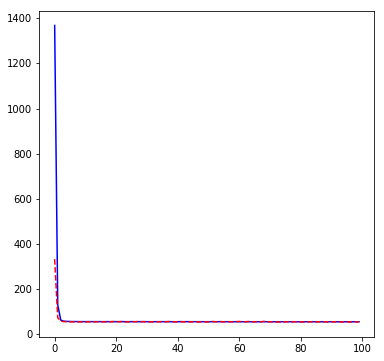

In [240]:
hist_s1=pd.DataFrame(history_s1.history)
hist_s1['epoch']=history_s1.epoch
fig,ax=plt.subplots(1,1,figsize=(6,6))
#ax.set_yscale('log')
#ax.set_ylim((40,100))
ax=plt.plot(hist_s1['epoch'],hist_s1['mean_squared_error'],'b-')
ax=plt.plot(hist_s1['epoch'],hist_s1['val_mean_squared_error'],'r--')
model_s1.evaluate(norm_data_test_s1,labels_test_s1,verbose=2)

Text(0.5, 1.0, 'Prediction vs train')

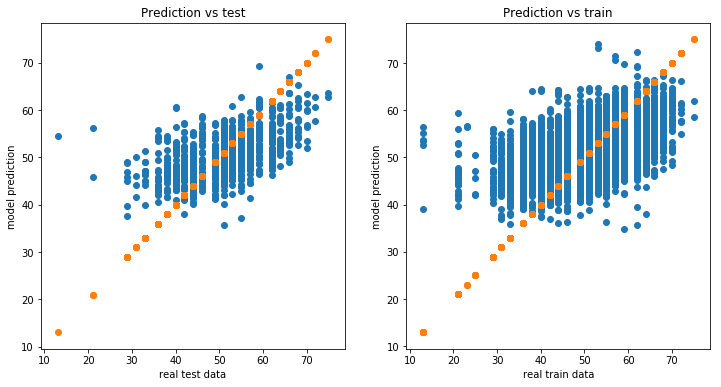

In [241]:
test_predictions = model_s1.predict(norm_data_test_s1).flatten()
train_predictions = model_s1.predict(norm_data_train_s1).flatten()

fig,ax = plt.subplots(1,2,figsize=(12,6))

ax[0].scatter(labels_test_s1,test_predictions)
ax[0].scatter(labels_test_s1,labels_test_s1)

ax[1].scatter(labels_train_s1,train_predictions)
ax[1].scatter(labels_train_s1,labels_train_s1)

ax[0].set_xlabel('real test data')
ax[0].set_ylabel('model prediction')
ax[0].set_title('Prediction vs test')

ax[1].set_xlabel('real train data')
ax[1].set_ylabel('model prediction')
ax[1].set_title('Prediction vs train')

### STEP 4 -- Conclusions

Both models for women and men seem to have very poor performance due to underfitting. We have checked that the performance does not improve when considering more complex models (deeper and larger neural network). It seems that it is hard to make a valid prediction of the max performance of a climber based on hers/his height, weight, age, sex, climbing type preferences and years of experience.<br>
We do not expect that one can improve the performance of the model by collecting more data. We have seen that the relation between the climbers performance and different parameters is very weak and that the noise is the data is quite substantial. Because different input parameters are also not strongly correlated, we do not expect some hidden correlation to suddenly improve the performance. It seems that the model's optimal guess is just to assume approximately average value of _max_grade_ and compensating the guess slightly due to the age and weight of the climber.